# SLT-CE-1: Locally Linear Embedding

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils.validation import check_is_fitted

from sklearn.manifold import LocallyLinearEmbedding as SklearnLLE

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<p style="background-color:#adebad;">
The MNIST data set contains three sets: **mnist.train, mnist.validation, mnist.test**  
Each of them is a numpy array with samples along rows, and pixels along columns.   
The original shape of the images is 28x28 = 784.
</p>

In [3]:
mnist.train.images.shape

(55000, 784)

In [4]:
mnist.validation.images.shape

(5000, 784)

In [5]:
mnist.test.images.shape

(10000, 784)

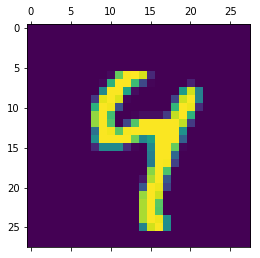

In [6]:
plt.matshow(mnist.train.images[2].reshape(28,28))
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Shortly recapitulate the Locally Linear Embedding (LLE) algorithm, and the involved formulas.
</p>

Put your markdown text here (it can also do Latex, just put it between two dollar signs! $\sum$)

1. Find the $k$-nearest neighbours for each data point $\mathbf x_i$.
2. Compute the weights $w_{ij}$ that best reconstructs all $\mathbf x_i$ from its neighbours, i.e. consider
\begin{align*}
    &\min_{\mathbf W} \sum_i \left\lVert\mathbf x_i - \sum_j w_{ij}\mathbf x_j\right\rVert^2 \\
    &\text{s.t.} \quad w_{ij} = 0 \text{ if $\mathbf x_j$ is not in the neighbourhood of $\mathbf x_i$, and} \\
    &\hphantom{s.t.} \quad \sum_j w_{ij} = 1,
\end{align*}
which has solution
$$
    w_{ij} = \frac{\sum_k c_{jk}^{(i)-1}}{\sum_{lk}c_{lk}^{(i)-1}},
$$
where $c_{jk}^{(i)} = (\mathbf x_i - \boldsymbol{\mathbf \eta}_j)^\intercal(\mathbf x_i - \boldsymbol{\mathbf \eta}_k)$ with $\boldsymbol{\mathbf \eta}_*$ being data points in neighbourhood of $\mathbf x_i$, and $\mathbf C^{(i)-1}$ is its inverse.
3. Compute the vectors $\mathbf y_i$ best reconstructed by the weights $w_{ij}$, i.e. consider
\begin{align*}
    &\min_{\mathbf y_1,\ldots,\mathbf y_N} \sum_i \left\lVert\mathbf y_i - \sum_j w_{ij}\mathbf y_j\right\rVert^2 \\
    &\text{s.t.} \sum_i \mathbf y_i = \mathbf 0 \text{, and} \\
    &\hphantom{s.t.} \frac{1}{N} \sum_i \mathbf y_i \mathbf y_i^\intercal = \mathbf I,
\end{align*}
    Then, the $\mathbf y$s are the bottom $d+1$ eigenvectors of $\mathbf M = (\mathbf I - \mathbf W)^\intercal(\mathbf I - \mathbf W)$ with the bottom eigenvector discarded.

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.<br>
    In particular, use the class attribute (variable) names as provided, and introduce new class attributes only if necessary.
</p>

In [7]:
class LocallyLinearEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for LLE, compare to `sklearn LLE`_.
    
    Attributes:
        embedding_vectors_ (np.ndarray): Embedding of input X with shape (samples, n_components)
        nbrs_X (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for training set X.
        nbrs_y (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for embedding_vectors_.
        M_ (np.array): Symmetric matrix (samples, samples), used in quadratic form for embedding.
        X_ (np.array): Copy of training set with shape (samples, dim).
    
       .. _`sklearn LLE`: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html
    """
    
    def __init__(self, n_components=2, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
    
    def fit(self, X):
        """Compute LLE embedding of vectors X
        
        First, compute nbrs_X and M_.
        Finally, compute embedding_vectors_.
        
        Args:
            X (np.ndarray): Input array with shape (samples, dim)
        
        Returns:
            self
        """
        self.X_ = X
        self.nbrs_X = skl.neighbors.KDTree(X)
        nbrs = self.nbrs_X.query(X, k=self.n_neighbors+1, return_distance=False)
        
        W_ = np.zeros((X.shape[0], X.shape[0]))
        for idx, *nbrs in nbrs:
            C = (X[nbrs] - X[idx]).dot((X[nbrs] - X[idx]).T)
            W_[idx, nbrs] = np.linalg.solve(C, np.ones(self.n_neighbors))
            W_[idx, nbrs] /= np.sum(W_[idx, nbrs])
        
        self.M_ = (np.eye(X.shape[0], X.shape[0])-W_).T.dot(np.eye(X.shape[0], X.shape[0])-W_)
        # we may improve the speed of it if we use scipy, but it is not in the env so I didn't use it.
        self.M_eigval_, eigvec = np.linalg.eigh(self.M_)
        eigsort = self.M_eigval_.argsort()
        self.M_eigval_ = self.M_eigval_[eigsort]
        eigvec = eigvec[:, eigsort]
        self.embedding_vectors_ = eigvec[:, 1:self.n_components+1]
        self.nbrs_y = skl.neighbors.KDTree(self.embedding_vectors_)
        
        return self
        
    def transform(self, X):
        """Map new vectors X to embedding space
        
        Use the fitted model to map new vectors to the space with dimension n_components.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, dim)
            
        Returns:
            y (np.ndarray): Embedded vectors with shape (new_samples, n_components)
        """
        check_is_fitted(self, ["embedding_vectors_", "nbrs_X"])
        nbrs_new_X = self.nbrs_X.query(X, k=self.n_neighbors, return_distance=False)
        W_ = np.zeros((X.shape[0], self.X_.shape[0]))
        for idx, nbrs in enumerate(nbrs_new_X):
            C = (self.X_[nbrs] - X[idx]).dot((self.X_[nbrs] - X[idx]).T)
            W_[idx, nbrs] = np.linalg.solve(C, np.ones(self.n_neighbors))
            W_[idx, nbrs] /= np.sum(W_[idx, nbrs])
        y = np.empty((X.shape[0], self.n_components))
        for i in range(X.shape[0]):
            y[i] = np.dot(self.embedding_vectors_[nbrs_new_X[i]].T, W_[i, nbrs_new_X[i]])
        return y
        
    def inverse_transform(self, y):
        """Map new vectors y to input space with dimension dim.
        
        Use the fitted model to map vectors y to the original input space.
        
        Args:
            y (np.ndarray): Input array with shape (new_samples, n_components)
            
        Returns:
            X (np.ndarray): Vectors with shape (new_samples, dim)
        """
        check_is_fitted(self, ["embedding_vectors_", "X_", "nbrs_y"])
        nbrs_y = self.nbrs_y.query(y, k=self.n_neighbors, return_distance=False)
        W_ = np.zeros((y.shape[0], self.embedding_vectors_.shape[0]))
        for idx, nbrs in enumerate(nbrs_y):
            C = (self.embedding_vectors_[nbrs] - y[idx]).dot((self.embedding_vectors_[nbrs] - y[idx]).T)
            W_[idx, nbrs] = np.linalg.solve(C, np.ones(self.n_neighbors))
            W_[idx, nbrs] /= np.sum(W_[idx, nbrs])
        X = np.empty((y.shape[0], self.X_.shape[1]))
        for i in range(y.shape[0]):
            X[i] = np.dot(self.X_[nbrs_y[i]].T, W_[i, nbrs_y[i]])
        return X

<p style="background-color:#adebad;">
    Create an instance of your LLE class with default parameters and fit the MNIST validation set. Record the execution time (should be about 30 sec). Furthermore, create an instance of the sklearn LLE class, and fit it with the same parameters. Again record the execution time.  
    Note, the dots should be filled in by you.
</p>

In [8]:
%%time
myLLE = LocallyLinearEmbedding()
myLLE.fit(mnist.validation.images)

CPU times: user 1min 30s, sys: 1.03 s, total: 1min 31s
Wall time: 1min 6s


In [9]:
%%time
sklLLE = SklearnLLE(random_state=42)
sklLLE.fit(mnist.validation.images)

CPU times: user 49.4 s, sys: 121 ms, total: 49.5 s
Wall time: 47.1 s


<p style="background-color:#adebad;">
    Plot myLLE.embedding\_vectors\_ and sklLLE.embedding\_vectors\_ in two separate plots.
</p>

In [10]:
def plt_mnist(embedding, of="validation"):
    labels = getattr(mnist, of).labels
    
    if len(labels) != len(embedding):
        raise ValueError("Number of labels does not match number of embeddings")
    
    for label in range(10):
        idx = (labels == label)
        plt.scatter(embedding[idx, 0], embedding[idx, 1], alpha=0.5, label=str(label))
    plt.legend()

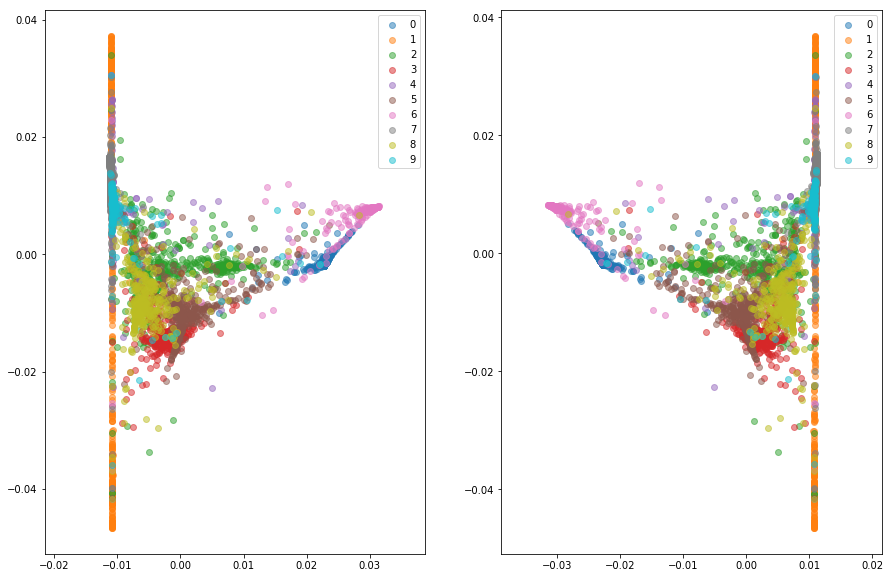

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt_mnist(sklLLE.embedding_)
plt.subplot(122)
plt_mnist(myLLE.embedding_vectors_) # <--- uncomment this!

<h2 style="background-color:#f0b375;"> Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a 4.5 on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        
        <li>Fit both, myLLE and sklLLE on the MNIST validation set, and use the fitted model to transform the MNIST test set.
        </li>
        
        <li>
            Plot both embeddings in two separate plots for comparison.
        </li>
    </ul>
</p>

In [12]:
%%time
my_embedding = myLLE.transform(mnist.test.images)

CPU times: user 1min 11s, sys: 84.3 ms, total: 1min 11s
Wall time: 1min 11s


In [13]:
%%time
skl_embedding = sklLLE.transform(mnist.test.images)

CPU times: user 1min 29s, sys: 176 ms, total: 1min 29s
Wall time: 1min 28s


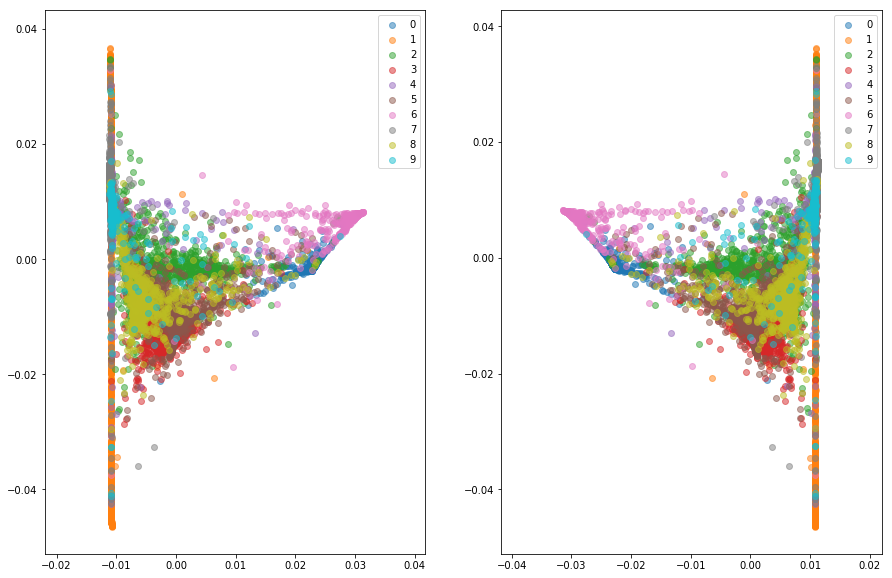

In [14]:
# Put the plots here
plt.figure(figsize=(15,10))
plt.subplot(121)
plt_mnist(skl_embedding, 'test')
plt.subplot(122)
plt_mnist(my_embedding, 'test')

<h2 style="background-color:#f0b375;"> Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a 5.0 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
    <li> Think how you can invert the LLE embedding, and shortly describe your approach.</li>
        <li> Using your approach, implement the <b>inverse_transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        <li>
        Use myLLE.transform and myLLE.inverse_transform to embed the first digit of the MNIST training set and then recover it. 
        </li>
       
My approach for LLE inverse:
1. Find the $k$-nearest neighbours for each embedded data point $\mathbf y_i'$.
2. Compute the weights $w_{ij}$ that best reconstructs all $\mathbf y_i'$ from its neighbours in the original embedded vectors $\mathbf y_i$ (the ones calculated during the `.fit` method), i.e. consider
\begin{align*}
    &\min_{\mathbf W} \sum_i \left\lVert\mathbf y_i' - \sum_j w_{ij}\mathbf y_j\right\rVert^2 \\
    &\text{s.t.} \quad w_{ij} = 0 \text{ if $\mathbf y_j$ is not in the neighbourhood of $\mathbf y_i'$, and} \\
    &\hphantom{s.t.} \quad \sum_j w_{ij} = 1,
\end{align*}
which has solution
$$
    w_{ij} = \frac{\sum_k c_{jk}^{(i)-1}}{\sum_{lk}c_{lk}^{(i)-1}},
$$
where $c_{jk}^{(i)} = (\mathbf y_i' - \boldsymbol{\mathbf \eta}_j)^\intercal(\mathbf y_i' - \boldsymbol{\mathbf \eta}_k)$ with $\boldsymbol{\mathbf \eta}_*$ being data points in neighbourhood of $\mathbf y_i'$, and $\mathbf C^{(i)-1}$ is its inverse.
3. For each $\mathbf y_i'$, we calculate the estimate of the vector in input space by
    $$ \hat{\mathbf x_i} = \sum_j w_{ij} \mathbf x_j. $$

Put the description of your approach to invert the LLE embedding here.

In [15]:
embedded_digit = myLLE.transform(mnist.train.images[[0]])
reconstructed_digit = myLLE.inverse_transform(embedded_digit)

<ul style="background-color:#adebad;">
        <li>
        Plot the original digit and the reconstructed digit for comparison.
        </li>
    </ul>

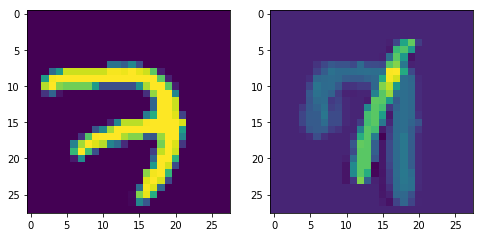

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(mnist.train.images[0].reshape(28,28))
plt.subplot(122)
plt.imshow(reconstructed_digit.reshape(28, 28))

<h2 style="background-color:#f0b375;"> Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a 5.5 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Perform a grid search of the reconstruction error, i.e. the trace of the matrix M_, over the parameters n_neighbors, and n_components.  
        Create a nice 2D heatmap of the results.
        </li>
    </ul>

In [25]:
errors = {}
for n_neighbors in [2, 3, 4, 5, 6, 7, 8, 15, 50, 100]:
    for n_components in [2, 3, 4, 5, 15, 50, 100]:
        LLE = LocallyLinearEmbedding(n_components, n_neighbors).fit(mnist.validation.images)
        errors[(n_components, n_neighbors)] = np.sum(LLE.M_eigval_[1:n_neighbors+1])
        print('Errors: ({}, {}): {}'.format(n_components, n_neighbors, np.sum(LLE.M_eigval_[1:n_components+1])))

Errors: (2, 2): -4.676642263419594e-15
Errors: (3, 2): -6.8694350132583316e-15
Errors: (4, 2): -9.011137609059557e-15
Errors: (5, 2): -1.1103429391859863e-14
Errors: (15, 2): -2.9055607842039325e-14
Errors: (50, 2): -6.379858730682746e-14
Errors: (100, 2): -5.6471318826654146e-14
Errors: (2, 3): -4.551063971516688e-16
Errors: (3, 3): -5.089415938482775e-16
Errors: (4, 3): -4.947189667781075e-16
Errors: (5, 3): -4.3262431320167997e-16
Errors: (15, 3): 1.482898430355232e-09
Errors: (50, 3): 0.003201471280900597
Errors: (100, 3): 0.056072878995434484
Errors: (2, 4): 1.2797244635230703e-10
Errors: (3, 4): 8.779946874261497e-08
Errors: (4, 4): 4.131835395023097e-07
Errors: (5, 4): 1.029892532337282e-06
Errors: (15, 4): 0.00023541132587616493
Errors: (50, 4): 0.029512079619454054
Errors: (100, 4): 0.2432184713792
Errors: (2, 5): 9.943148404982136e-07
Errors: (3, 5): 2.409963716340539e-06
Errors: (4, 5): 4.37806454546736e-06
Errors: (5, 5): 8.862178096140768e-06
Errors: (15, 5): 0.00118302434

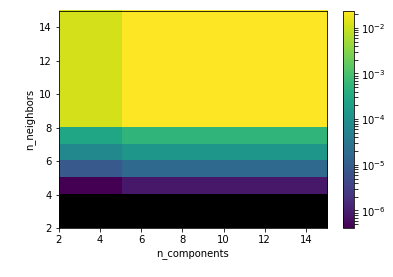

In [89]:
import copy
import matplotlib
my_cmap = copy.copy(matplotlib.cm.get_cmap('viridis')) # copy the default cmap
my_cmap.set_bad((0,0,0))
x = plt.hist2d(np.array(list(errors.keys()))[:, 0], np.array(list(errors.keys()))[:,1], 
           norm=matplotlib.colors.LogNorm(),
           cmap=my_cmap,
           weights=list(errors.values()), bins=[[2, 3, 4, 5, 15], [2, 3, 4, 5, 6, 7, 8, 15]])
im = x[-1]
im.set_extent(im.get_extent())  # <= workaround


plt.xlabel('n_components')
plt.ylabel('n_neighbors')
plt.colorbar()
plt.show()

<ul style="background-color:#adebad;">
        <li>
        Create a matrix plot of the matrix M\_.  
        Make sure to permute the rows and columns according to the digit labels, so that you can actually observe the block structure. Also make sure to scale the plot properly, so that you can observe the block structure. What is the origin of the block structure?
        </li>
        <li>
        Plot the spectrum (eigenvalues) of M\_. Can you identify a good cutoff? What could you use the value of the cutoff for?
        </li>
    </ul>

In [19]:
sorted_images = mnist.validation.images[np.argsort(mnist.validation.labels)][::40]
sortedLLE = LocallyLinearEmbedding().fit(sorted_images)

We can observe the block structure as follow. The block structure comes from that for an image of a specific digit $d$, we can quite easily reconstruct that image using other images with digit $d$.

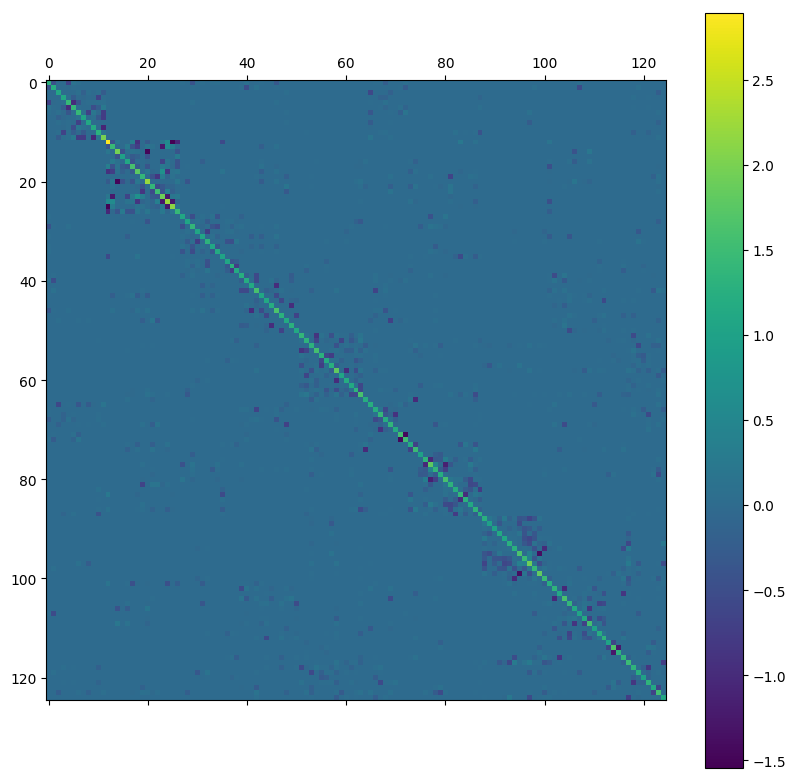

In [20]:
plt.figure(0, figsize=(10, 10), dpi=100)
plt.matshow(sortedLLE.M_, 0)
plt.colorbar()
plt.show()

The red vertical line seems to be a good cutoff. This means we can use the lowest 7 eigenvectors for reconstruction (discarding the lowest one) with a good balance between generalization and error.

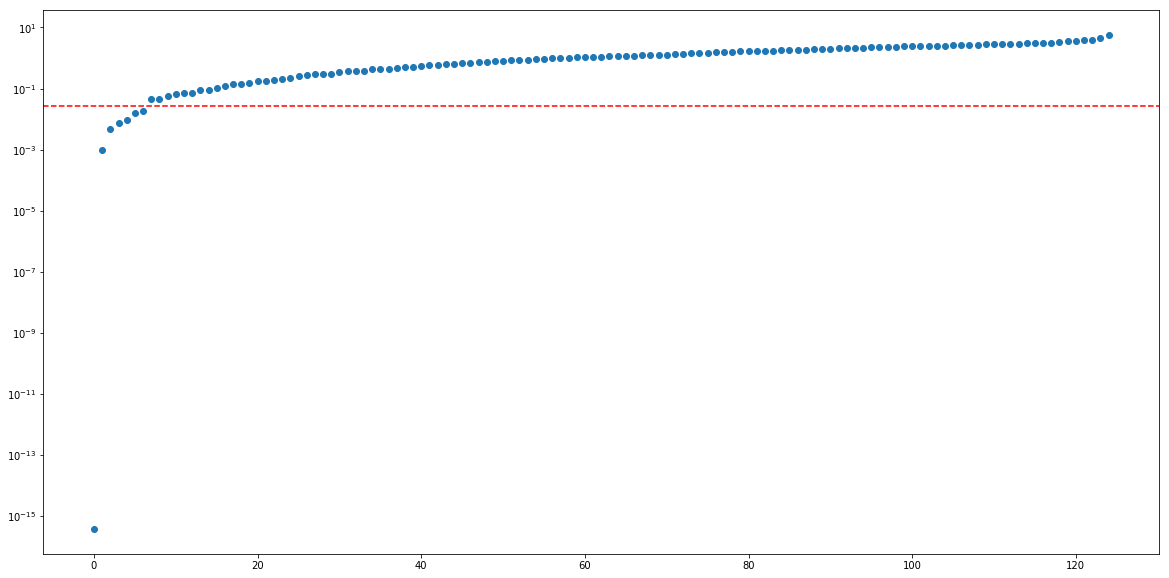

In [21]:
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.axhline(0.027, color='r', linestyle='--')
plt.plot(sorted(np.linalg.eigvals(sortedLLE.M_)), 'o')
plt.show()

<h2 style="background-color:#f0b375;"> Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a 6.0 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the linear interpolation between two digits $x_1,\ x_2$ in the input space compared to the reconstruction along the linear interpolation of their embeddings $y_1, y_2$. More precisely, compare $\lambda x_1 + (1-\lambda) x_2,\ \lambda\in[0,1]$ to $LLE^{-1}\big(\lambda y_1 + (1-\lambda) y_2\big),\ \lambda\in[0,1]$
        </li>
    </ul>

In [139]:
myLLE = LocallyLinearEmbedding(6, 5)
myLLE.fit(mnist.validation.images)

LocallyLinearEmbedding(n_components=6, n_neighbors=5)

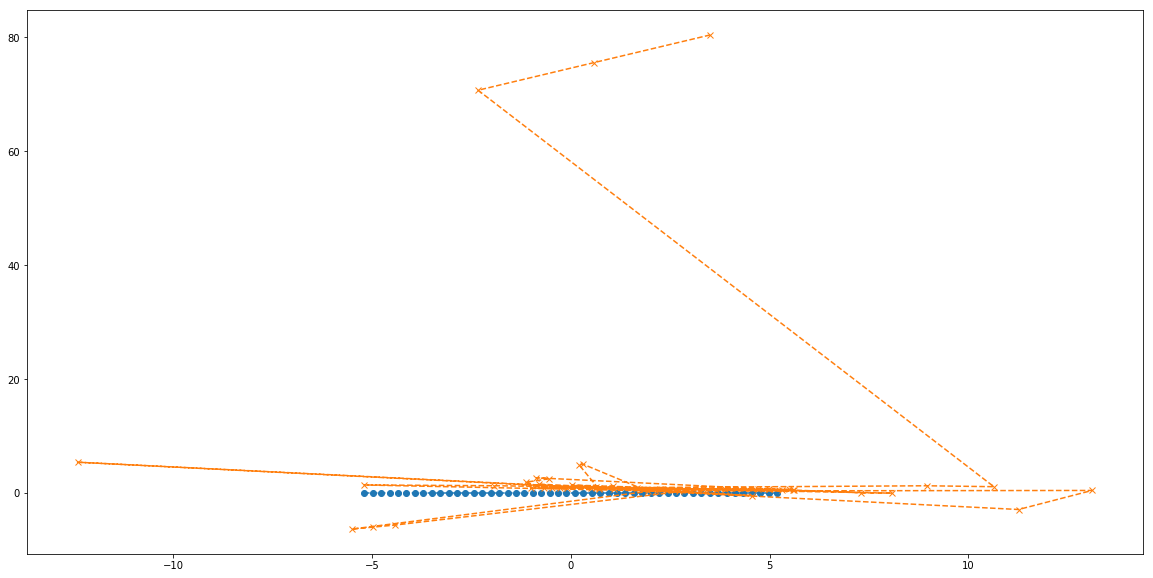

In [166]:
digit1 = mnist.test.images[[21]]
digit2 = mnist.test.images[[61]]
vectors_o = []
for lamb in np.linspace(0, 1, 50):
    im = lamb * digit1 + (1-lamb) * digit2
    vectors_o.append(im[0])
    
pca = skl.decomposition.PCA(2)
pca_o = pca.fit_transform(np.array(vectors_o))

vectors_e = []
embed1 = myLLE.transform(digit1)
embed2 = myLLE.transform(digit2)
for lamb in np.linspace(0, 1, 50):
    im = lamb * embed1 + (1-lamb) * embed2
    im = myLLE.inverse_transform(im)
    vectors_e.append(im[0])
    
pca_e = pca.transform(np.array(vectors_e))
plt.figure(figsize=(20, 10))
plt.plot(pca_o[:,0], pca_o[:, 1], 'o--', pca_e[:,0], pca_e[:,1], 'x--')
plt.show()

<ul style="background-color:#adebad;">
        <li>
        Select images of digits "6" and a digits "8".  
        Rotate the input images by 360° in steps of 1° and create the embedding of each rotation.  
        Create a nice plot of the respective trajectories in the 2D embedding space (Make sure to use markers for the embeddings, and connect them with a line. Use labels and legends, and add some embeddings of other digits to put the trajectories into context).
        </li>
    </ul>

In [114]:
myLLE = LocallyLinearEmbedding()
myLLE.fit(mnist.validation.images)

LocallyLinearEmbedding(n_components=2, n_neighbors=5)

In [119]:
import skimage.transform

digit6 = mnist.test.images[[21]].reshape(28, 28)
digit8 = mnist.test.images[[61]].reshape(28, 28)

digits6 = []
digits8 = []
for angle in range(360):
    digits6.append(skimage.transform.rotate(digit6, angle).reshape(-1))
    digits8.append(skimage.transform.rotate(digit8, angle).reshape(-1))
digits6 = np.array(digits6)
digits8 = np.array(digits8)

In [122]:
embed6 = myLLE.transform(digits6)
embed8 = myLLE.transform(digits8)

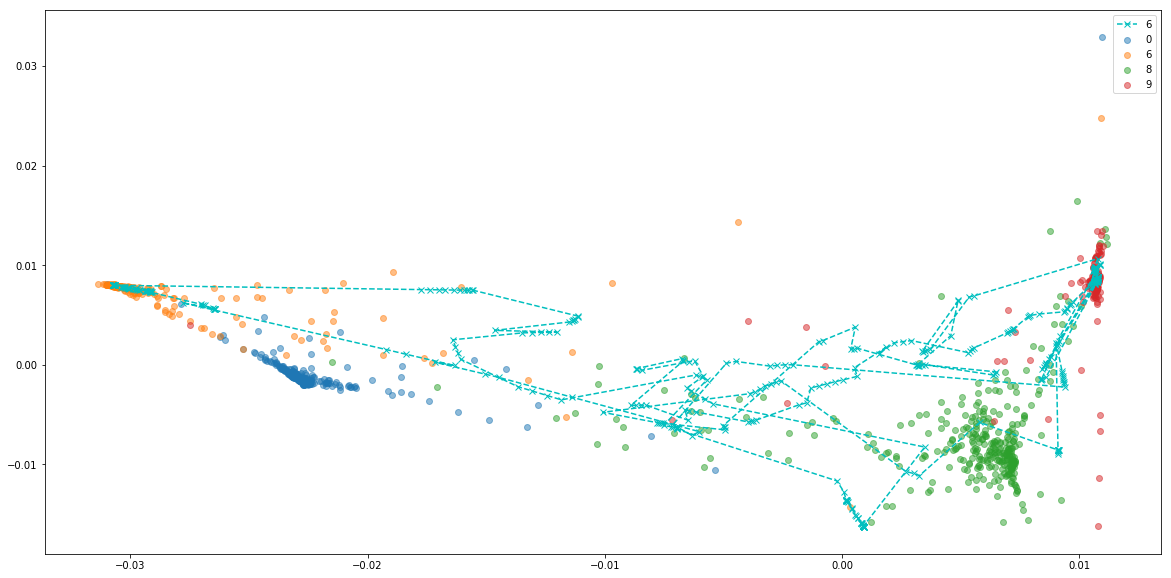

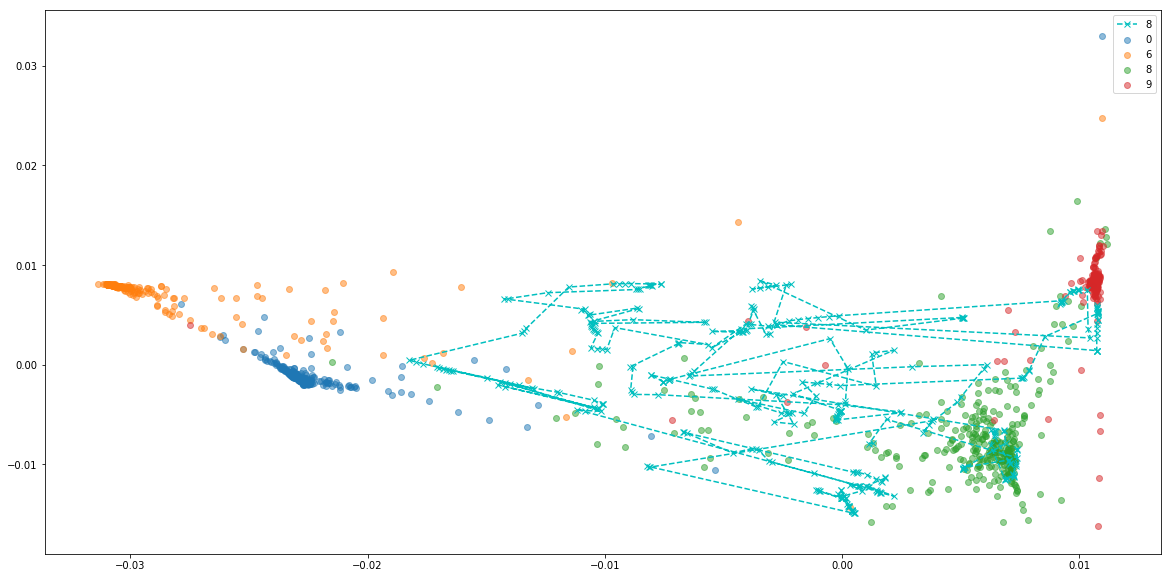

In [147]:
plt.figure(figsize=(20, 10))
plt.plot(embed6[:, 0], embed6[:, 1], 'cx--', label="6")

    
for label in [0, 6, 8, 9]:
    idx = (mnist.test.labels == label)
    plt.scatter(my_embedding[idx, 0][::3], my_embedding[idx, 1][::3], alpha=0.5, label=str(label))

plt.legend()

plt.figure(figsize=(20, 10))
plt.plot(embed8[:, 0], embed8[:, 1], 'cx--', label="8")

    
for label in [0, 6, 8, 9]:
    idx = (mnist.test.labels == label)
    plt.scatter(my_embedding[idx, 0][::3], my_embedding[idx, 1][::3], alpha=0.5, label=str(label))

plt.legend()


plt.show()